# Supply management analysis

The files contain the following columns:
* los_pick_id = unique pick ID
* los_order_id = unique order ID
* art_id = unique article ID of the picked article
* to_pick = the number of pieces to be picked
* weight = weight of 1 piece of this article
* volume = volume of 1 piece of this article
* tour_id = unique tour ID (there are different tour types depending on the box _types)
* box_position_on_cart = number of the box on the cart
* box_type = type of the box (essentially encoding an interval of volumes)
* pick_start_date = start of the pick = scan of the article barcode
* pick_end_date = end of the pick = scan of the correct box on the cart 

**Task**:  For a given tour_id predict the picking times of each pick on that tour.

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import seaborn as sns

# Data Preparation

In [149]:
# read data
data1 = pd.read_csv('Picks_09-2019.csv', sep=';', parse_dates=['pick_start_date'])

# change datetime
data1.pick_start_date = pd.to_datetime(data1.pick_start_date, format='%Y-%m-%d-%H.%M.%S.%f')
data1.pick_end_date = pd.to_datetime(data1.pick_end_date, format='%Y-%m-%d-%H.%M.%S.%f')

# time for order in sec
data1['order_time_sec'] = (data1.pick_start_date - data1.pick_end_date).dt.total_seconds() * -1

# does not play 
data1.drop(['los_pick_id', 'Unnamed: 11', 'pick_start_date', 'pick_end_date'], axis=1, inplace=True) 

# replace values of box type
data1.box_type = data1.box_type.map({'GRÜN':1, 'WEISS':2, 'BLAU':3, 'SCHWARZ':4, 'ROT':5, \
                                     'onePos_LX':6, 'GELB':7})

In [161]:
# Data head
data1.head(2)

,los_order_id,art_id,to_pick,weight,volume,tour_id,box_position_on_cart,box_type,order_time_sec
0,1698349,465337,1,0.28,840.84,209946,11,GRÜN,4.024952
1,1698349,321159,1,0.28,840.84,209946,11,GRÜN,1.637162


### Here we have 
* 1_670_433 records in one file
* 144_205 orders of 
* 21052 tour id
* 18_549 art_ids
* 42 type of boxes in 
* 7 box_types

### let us see the number of items per order

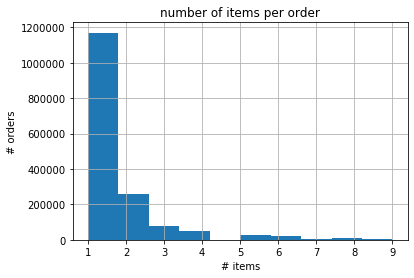

In [153]:
data1[data1.to_pick < 10].to_pick.hist()
plt.title('number of items per order')
plt.ylabel('# orders')
plt.xlabel('# items')
plt.show();

##### most of the orders are 1-2 items 

### Let check the correlation

In [185]:
data1.corr()

,art_id,to_pick,weight,volume,tour_id,box_position_on_cart,order_time_sec
art_id,1.000000,-0.046375,0.034754,0.063975,0.021471,0.076718,-0.006702
to_pick,-0.046375,1.000000,-0.032950,-0.038637,-0.003180,-0.068670,0.060634
weight,0.034754,-0.032950,1.000000,0.805075,-0.007216,-0.153079,0.021844
volume,0.063975,-0.038637,0.805075,1.000000,-0.000211,-0.137450,0.019742
tour_id,0.021471,-0.003180,-0.007216,-0.000211,1.000000,0.017314,-0.006067
box_position_on_cart,0.076718,-0.068670,-0.153079,-0.137450,0.017314,1.000000,-0.010308
order_time_sec,-0.006702,0.060634,0.021844,0.019742,-0.006067,-0.010308,1.000000


### So the los_order_id is equal tour_id! and we can drop it

In [ ]:
data1.drop(['los_order_id'], axis=1, inplace=True) 

## Q2: Find groups of articles with a similar picking time behavior.
### clusters with K Means algoritm


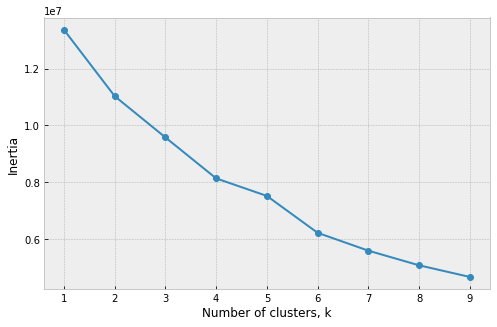

In [206]:
# scale data
scale = StandardScaler()
data_scaled = scale.fit_transform(data1)

# check for the better value of k
ks = range(1, 10)
inertias = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k)
    model.fit(data_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show();


### Let use 6 clusters

In [207]:
# Set 6 clusters
final_model = KMeans(n_clusters=6, n_init=50,
    max_iter=500, random_state=11)

# fit model
final_model.fit(data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=6, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=11, tol=0.0001, verbose=0)

In [209]:
# add to initial dataset
data1['num_cluster'] = final_model.predict(data_scaled)

### Here is the cluster distribution 

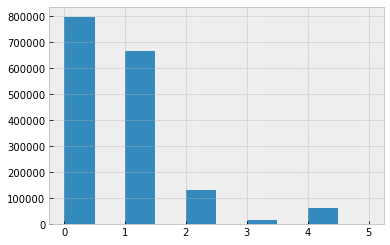

In [212]:
data1.num_cluster.hist()
plt.show();

#### Most of the ordres are in first two clusters. Let us look closer

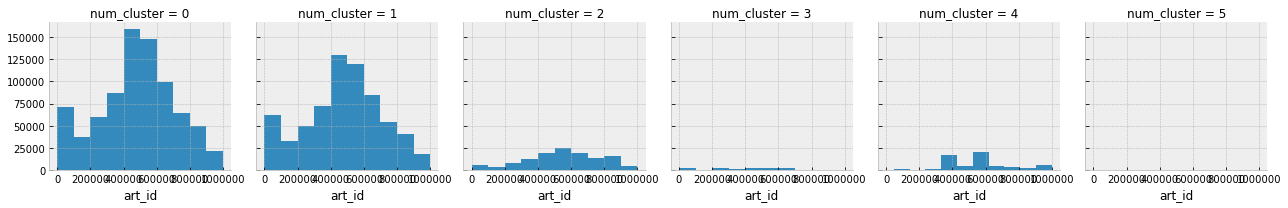

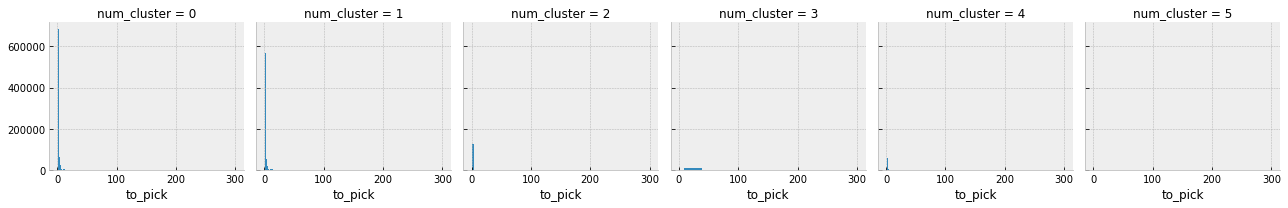

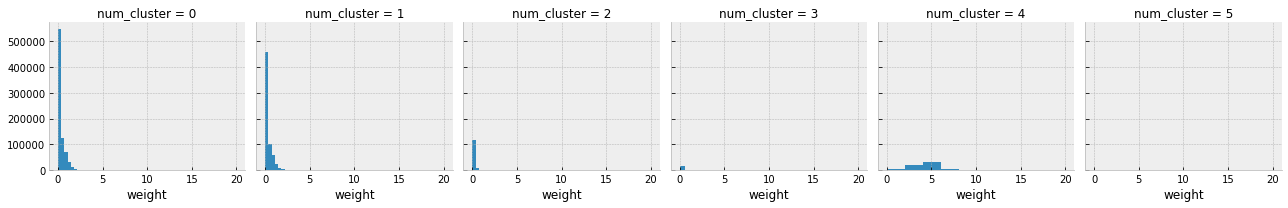

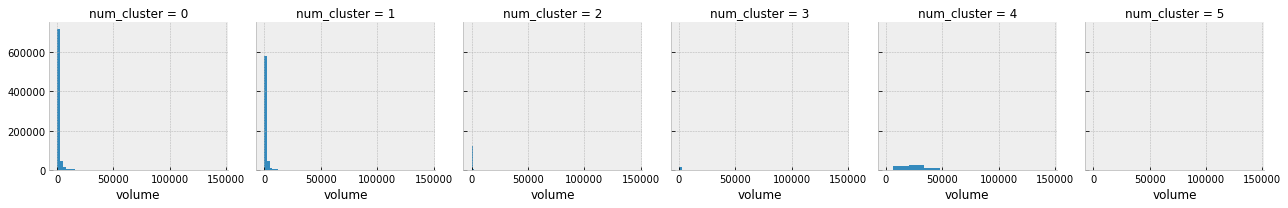

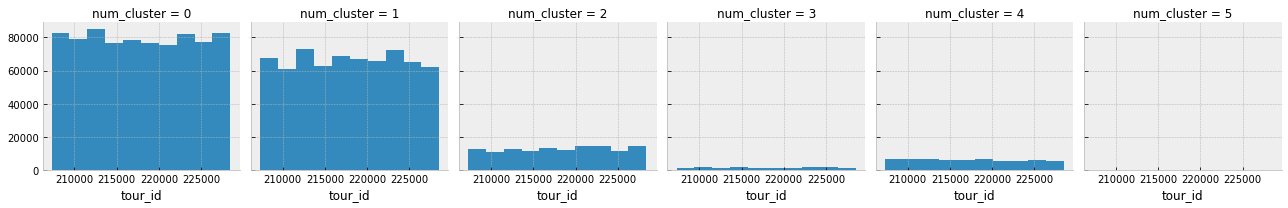

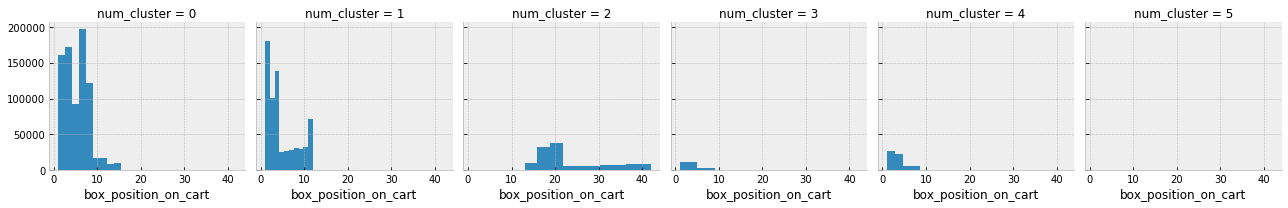

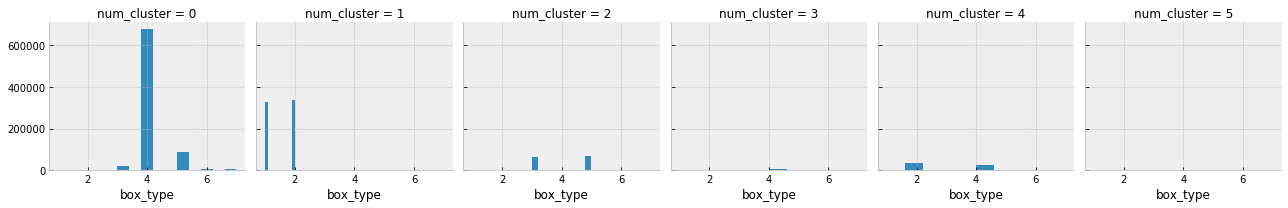

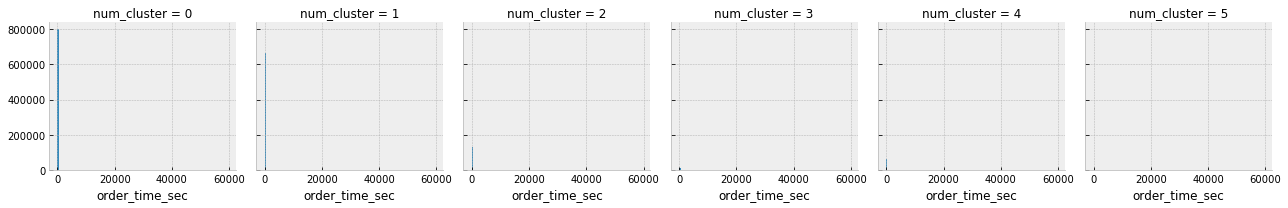

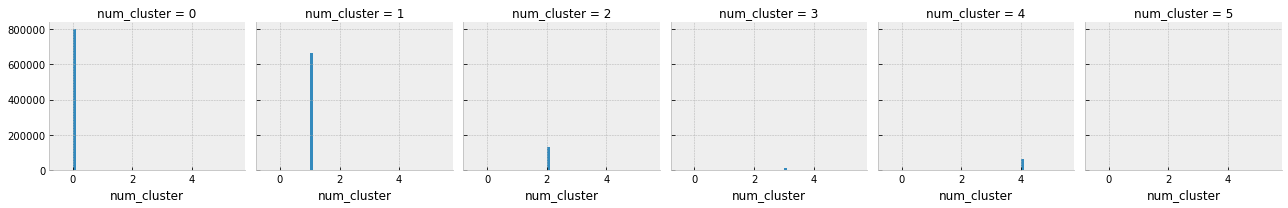

In [216]:
for c in data1:
    grid = sns.FacetGrid(data1, col='num_cluster')
    grid.map(plt.hist, c)

### we can clearly see that 1 and 2 cluster are charactrezed by
- box types are 4 (SCHWARZ) for 1 cluster, and WEISEE for 2 cluster
- box position on cart up to 15
- order time a take most of the total time


## Q1: Find a formula for each article or article groups that predicts the picking time of n pieces of this article/these articles.

In [232]:
# use simple cat model 
cat = CatBoostRegressor()

In [233]:
# select cat features
categorical_features = ['box_type', 'box_position_on_cart', 'tour_id', 'art_id', 'num_cluster']

In [236]:
# split dataset to check the performance
X_train, X_test, y_train, y_test = train_test_split(data1.drop('order_time_sec', axis=1), 
                                                    data1.order_time_sec, \
                                                   random_state=11, shuffle=True)

In [238]:
# fit model
cat.fit(X_train, y_train, categorical_features, verbose=0)

Learning rate set to 0.138939
0:	learn: 101.1493042	total: 415ms	remaining: 6m 54s
1:	learn: 93.6863711	total: 665ms	remaining: 5m 31s
2:	learn: 86.0011290	total: 1.13s	remaining: 6m 14s
3:	learn: 78.8740053	total: 1.4s	remaining: 5m 49s
4:	learn: 72.8511104	total: 1.67s	remaining: 5m 31s
5:	learn: 67.7392985	total: 1.93s	remaining: 5m 20s
6:	learn: 63.2828973	total: 2.16s	remaining: 5m 6s
7:	learn: 59.3809820	total: 2.51s	remaining: 5m 10s
8:	learn: 56.0031333	total: 2.76s	remaining: 5m 4s
9:	learn: 53.3502261	total: 3.18s	remaining: 5m 14s
10:	learn: 50.9726498	total: 3.35s	remaining: 5m 1s
11:	learn: 48.8401103	total: 3.56s	remaining: 4m 53s
12:	learn: 46.6311269	total: 3.78s	remaining: 4m 47s
13:	learn: 44.8167541	total: 4.02s	remaining: 4m 43s
14:	learn: 42.8967847	total: 4.29s	remaining: 4m 41s
15:	learn: 41.4469641	total: 4.48s	remaining: 4m 35s
16:	learn: 39.9469712	total: 4.84s	remaining: 4m 40s
17:	learn: 39.0401754	total: 4.99s	remaining: 4m 32s
18:	learn: 37.7006206	total: 

154:	learn: 19.9471717	total: 37.9s	remaining: 3m 26s
155:	learn: 19.9396958	total: 38.3s	remaining: 3m 27s
156:	learn: 19.9296746	total: 38.5s	remaining: 3m 26s
157:	learn: 19.9248900	total: 38.7s	remaining: 3m 26s
158:	learn: 19.9175873	total: 39.1s	remaining: 3m 26s
159:	learn: 19.9068623	total: 39.5s	remaining: 3m 27s
160:	learn: 19.8990174	total: 39.7s	remaining: 3m 26s
161:	learn: 19.8981396	total: 40s	remaining: 3m 26s
162:	learn: 19.8888640	total: 40.3s	remaining: 3m 27s
163:	learn: 19.8801249	total: 40.6s	remaining: 3m 26s
164:	learn: 19.8778412	total: 40.9s	remaining: 3m 26s
165:	learn: 19.8713102	total: 41s	remaining: 3m 26s
166:	learn: 19.8689246	total: 41.2s	remaining: 3m 25s
167:	learn: 19.8615056	total: 41.4s	remaining: 3m 24s
168:	learn: 19.8520357	total: 41.6s	remaining: 3m 24s
169:	learn: 19.8509260	total: 41.9s	remaining: 3m 24s
170:	learn: 19.8454868	total: 42.1s	remaining: 3m 24s
171:	learn: 19.8443330	total: 42.4s	remaining: 3m 23s
172:	learn: 19.8436022	total: 42

306:	learn: 19.5312945	total: 1m 28s	remaining: 3m 18s
307:	learn: 19.5299294	total: 1m 28s	remaining: 3m 18s
308:	learn: 19.5272996	total: 1m 28s	remaining: 3m 18s
309:	learn: 19.5262224	total: 1m 29s	remaining: 3m 18s
310:	learn: 19.5247464	total: 1m 29s	remaining: 3m 18s
311:	learn: 19.5242386	total: 1m 29s	remaining: 3m 18s
312:	learn: 19.5237797	total: 1m 30s	remaining: 3m 18s
313:	learn: 19.5221399	total: 1m 30s	remaining: 3m 18s
314:	learn: 19.5212461	total: 1m 31s	remaining: 3m 18s
315:	learn: 19.5196636	total: 1m 31s	remaining: 3m 18s
316:	learn: 19.5194819	total: 1m 31s	remaining: 3m 18s
317:	learn: 19.5185536	total: 1m 32s	remaining: 3m 18s
318:	learn: 19.5161865	total: 1m 33s	remaining: 3m 18s
319:	learn: 19.5096825	total: 1m 33s	remaining: 3m 18s
320:	learn: 19.5076337	total: 1m 33s	remaining: 3m 18s
321:	learn: 19.5074346	total: 1m 34s	remaining: 3m 18s
322:	learn: 19.5015852	total: 1m 34s	remaining: 3m 17s
323:	learn: 19.5010681	total: 1m 34s	remaining: 3m 17s
324:	learn

457:	learn: 19.3839108	total: 2m 24s	remaining: 2m 50s
458:	learn: 19.3829999	total: 2m 24s	remaining: 2m 50s
459:	learn: 19.3825440	total: 2m 25s	remaining: 2m 50s
460:	learn: 19.3821369	total: 2m 25s	remaining: 2m 50s
461:	learn: 19.3820295	total: 2m 26s	remaining: 2m 50s
462:	learn: 19.3819035	total: 2m 26s	remaining: 2m 50s
463:	learn: 19.3798761	total: 2m 27s	remaining: 2m 49s
464:	learn: 19.3797988	total: 2m 27s	remaining: 2m 49s
465:	learn: 19.3792771	total: 2m 27s	remaining: 2m 49s
466:	learn: 19.3785546	total: 2m 28s	remaining: 2m 48s
467:	learn: 19.3775179	total: 2m 28s	remaining: 2m 48s
468:	learn: 19.3726335	total: 2m 28s	remaining: 2m 48s
469:	learn: 19.3723840	total: 2m 28s	remaining: 2m 47s
470:	learn: 19.3717475	total: 2m 29s	remaining: 2m 47s
471:	learn: 19.3701967	total: 2m 29s	remaining: 2m 47s
472:	learn: 19.3700774	total: 2m 30s	remaining: 2m 47s
473:	learn: 19.3696791	total: 2m 30s	remaining: 2m 47s
474:	learn: 19.3694836	total: 2m 31s	remaining: 2m 46s
475:	learn

607:	learn: 19.2598769	total: 3m 21s	remaining: 2m 9s
608:	learn: 19.2592749	total: 3m 21s	remaining: 2m 9s
609:	learn: 19.2591551	total: 3m 22s	remaining: 2m 9s
610:	learn: 19.2590558	total: 3m 22s	remaining: 2m 9s
611:	learn: 19.2587053	total: 3m 23s	remaining: 2m 8s
612:	learn: 19.2584231	total: 3m 23s	remaining: 2m 8s
613:	learn: 19.2580175	total: 3m 24s	remaining: 2m 8s
614:	learn: 19.2574440	total: 3m 24s	remaining: 2m 8s
615:	learn: 19.2570497	total: 3m 25s	remaining: 2m 8s
616:	learn: 19.2568672	total: 3m 25s	remaining: 2m 7s
617:	learn: 19.2566229	total: 3m 26s	remaining: 2m 7s
618:	learn: 19.2562645	total: 3m 26s	remaining: 2m 7s
619:	learn: 19.2543826	total: 3m 27s	remaining: 2m 7s
620:	learn: 19.2539524	total: 3m 27s	remaining: 2m 6s
621:	learn: 19.2538644	total: 3m 28s	remaining: 2m 6s
622:	learn: 19.2536440	total: 3m 28s	remaining: 2m 6s
623:	learn: 19.2534779	total: 3m 29s	remaining: 2m 6s
624:	learn: 19.2532872	total: 3m 29s	remaining: 2m 5s
625:	learn: 19.2530045	total

758:	learn: 19.1176673	total: 4m 22s	remaining: 1m 23s
759:	learn: 19.1176321	total: 4m 23s	remaining: 1m 23s
760:	learn: 19.1174190	total: 4m 23s	remaining: 1m 22s
761:	learn: 19.1174094	total: 4m 24s	remaining: 1m 22s
762:	learn: 19.1167146	total: 4m 24s	remaining: 1m 22s
763:	learn: 19.1165512	total: 4m 25s	remaining: 1m 21s
764:	learn: 19.1091409	total: 4m 25s	remaining: 1m 21s
765:	learn: 19.1088343	total: 4m 25s	remaining: 1m 21s
766:	learn: 19.1085730	total: 4m 26s	remaining: 1m 20s
767:	learn: 19.1084263	total: 4m 26s	remaining: 1m 20s
768:	learn: 19.1083637	total: 4m 26s	remaining: 1m 20s
769:	learn: 19.1082362	total: 4m 27s	remaining: 1m 19s
770:	learn: 19.1080962	total: 4m 27s	remaining: 1m 19s
771:	learn: 19.1080091	total: 4m 27s	remaining: 1m 19s
772:	learn: 19.1079659	total: 4m 28s	remaining: 1m 18s
773:	learn: 19.1065364	total: 4m 28s	remaining: 1m 18s
774:	learn: 19.1062880	total: 4m 28s	remaining: 1m 18s
775:	learn: 19.1058067	total: 4m 29s	remaining: 1m 17s
776:	learn

910:	learn: 19.0259699	total: 5m 24s	remaining: 31.7s
911:	learn: 19.0255880	total: 5m 24s	remaining: 31.4s
912:	learn: 19.0253657	total: 5m 25s	remaining: 31s
913:	learn: 19.0252305	total: 5m 26s	remaining: 30.7s
914:	learn: 19.0252081	total: 5m 26s	remaining: 30.3s
915:	learn: 19.0245224	total: 5m 26s	remaining: 30s
916:	learn: 19.0243114	total: 5m 27s	remaining: 29.6s
917:	learn: 19.0240099	total: 5m 27s	remaining: 29.2s
918:	learn: 19.0238849	total: 5m 28s	remaining: 28.9s
919:	learn: 19.0232603	total: 5m 28s	remaining: 28.6s
920:	learn: 19.0230974	total: 5m 28s	remaining: 28.2s
921:	learn: 19.0230224	total: 5m 29s	remaining: 27.9s
922:	learn: 19.0230078	total: 5m 29s	remaining: 27.5s
923:	learn: 19.0194281	total: 5m 30s	remaining: 27.2s
924:	learn: 19.0193543	total: 5m 30s	remaining: 26.8s
925:	learn: 19.0170185	total: 5m 31s	remaining: 26.5s
926:	learn: 19.0169307	total: 5m 31s	remaining: 26.1s
927:	learn: 19.0166087	total: 5m 32s	remaining: 25.8s
928:	learn: 19.0151901	total: 5m

In [252]:
# R2 metric for contunue data
r2_score(y_test, cat.predict(X_test))

0.90663477497294

### We have receive a pretty good results (max is 1, we have 0.91) using R2 metrics with any tuning or feature engineering

### For example let predict time of delivery for the first 12 items with tour_id

In [361]:
# prepare results
dd, ff, gg = [], [], []
for i in range(12):
    dd.append(X_train.art_id.iloc[i])
    ff.append(X_train.tour_id.iloc[i])
    gg.append(y_train.iloc[i])
dd = pd.DataFrame(cat.predict(X_train.iloc[:12]), [dd, ff, gg]).reset_index()
dd.columns = ['Art_id', 'Tour_id', 'Predicted_Time_to_deliver_seconds', 'real_time_to_deliver']
dd

,Art_id,Tour_id,Predicted_Time_to_deliver_seconds,real_time_to_deliver
0,707064,221428,2.294744,3.174448
1,492036,217926,5.214839,7.952786
2,836564,227150,5.803776,5.953270
3,605102,210134,2.782168,6.825035
4,567945,213655,6.444398,8.187759
5,499897,210470,2.000733,3.066388
6,989379,222787,1.610479,3.648951
7,647081,223068,1.278935,1.957613
8,660448,220325,1.096020,3.181986
9,715908,224189,3.945619,6.111307


### Now we can check the feature inportance for such results 

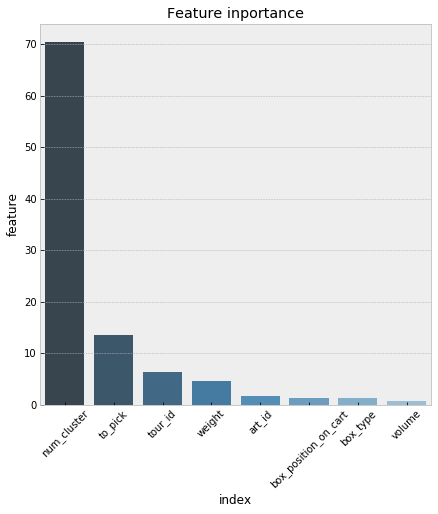

In [257]:
ddd = pd.DataFrame(cat.feature_importances_, X_train.columns, columns=["feature"])
ddd = ddd.sort_values(by='feature', ascending=False).reset_index()
plt.figure(figsize=[7,7])
sns.barplot(x='index', y='feature', data=ddd[:75], palette="Blues_d")
plt.title('Feature inportance')
plt.xticks(rotation=45)
plt.show();

### We see that cluster (that describe the items) are most importance for time devivery. Next is number of items to pick than we have tour_id (road)


## Q3: Find articles with an unusual picking time behavior (either compared to the group they belong to or compared to their picking time behavior say two weeks ago). These are articles that need to be checked in the warehouse to identify the reason.

In [364]:
def find_outliers(data, columns, coeff=1.5):
    _iqr = np.percentile(data[columns], 75, interpolation='midpoint') \
                        - np.percentile(data[columns], 25, interpolation='midpoint')
    
    new = data[
        (data[columns] <= np.percentile(data[columns], 25, interpolation='midpoint') - _iqr * coeff) |
        (data[columns] >= np.percentile(data[columns], 75, interpolation='midpoint') + _iqr * coeff)
            ]
    return new

find_outliers(data1, 'order_time_sec')

,art_id,to_pick,weight,volume,tour_id,box_position_on_cart,box_type,order_time_sec,num_cluster
9,654493,16,0.055,530.05,209705,10,1,23.538097,1
11,623986,26,0.045,284.46,209705,10,1,63.525388,3
12,635906,10,0.129,457.22,209705,10,1,26.674380,1
13,94209,10,0.019,324.90,209705,10,1,43.773421,1
14,848000,1,0.460,1470.00,209873,4,1,20.421825,1
...,...,...,...,...,...,...,...,...,...
1670403,635946,12,0.095,351.00,220582,3,1,21.880534,1
1670404,306625,5,0.152,270.40,220582,3,1,20.949801,1
1670407,523823,3,0.443,803.25,220582,3,1,29.147089,1
1670408,810818,5,0.232,499.55,220582,3,1,25.329578,1


### Here we used the standard criterion to search for 1.5 times more than the inter-quarter gap

We received approximately 160 thousand purchases. (this is about 10%) 
* Obviously, you need to increase to 2 in order to understand in detail the reasons for such deviations.

In [368]:
find_outliers(data1, 'order_time_sec', coeff=2)

,art_id,to_pick,weight,volume,tour_id,box_position_on_cart,box_type,order_time_sec,num_cluster
11,623986,26,0.045,284.46,209705,10,1,63.525388,3
12,635906,10,0.129,457.22,209705,10,1,26.674380,1
13,94209,10,0.019,324.90,209705,10,1,43.773421,1
30,435181,5,0.980,2873.56,210317,3,2,38.670486,1
31,577549,4,0.559,1093.37,210317,2,2,42.663700,1
...,...,...,...,...,...,...,...,...,...
1670353,304713,5,0.292,1720.40,224024,8,1,30.957502,1
1670359,452581,4,1.200,7007.35,224476,8,4,56.243965,0
1670407,523823,3,0.443,803.25,220582,3,1,29.147089,1
1670408,810818,5,0.232,499.55,220582,3,1,25.329578,1


### Unfortunately more than 7% is outlers for delivery time!

#### We need to explore the issues of such statistics 

______________________________________________________________________________________________________

### Next questions needs more domain knowledge and is out of standard scope of test case

Q4: These questions extend to (total) picking times of an order (= many picks) and to any duration time like waiting times.Q5: Identify article properties that influence picking times the  most. (Relates to Q2.)

Q6: In the packing area we also know duration times: from scanning the box containing an order to confirming that the order has been packed. Here, we don't know how long each intermediate step for each article piece took. Maybe some articles need extra handling, like packing them into a bag. Others don't. But we do not have an indicator in the article data. So, find a way to predict the packaging time of an order knowing its content. (We need to learn processing times from the past.) Maybe some deep learning algorithms/neural networks could come in handy here. Maybe other non-trivial approaches. I would expect a data-scientist to know how to attack such a problem, to test several potential models and find and tune a best one on real data.

Q7: We compute many KPIs for a warehouse and keep track of them over time. Find relations among time, even with a time-shift, so if one KPI goes down we could identify other KPIs that go or went up/down at the same time or even hours before...and thus could serve as an explanation why the KPI of interest goes down.

Q8: Related to Q6: Sometimes we do not have pure picking times but only times between the end scans of two picks. Knowing the distance between two picks, try and learn to distinguish between the walking speed/time and picking time...in the same way as we learned to distinguish packing times of two articles. Do we actually need the distance between the two picks? (It definitely helps, but would it be possible only knowing storage locations from which we pick but not the distance between the two locations?)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Thank you for reading, pls you may contact by https://www.linkedin.com/in/volodymyrgavrish/